/var/folders/r0/3946nhpj0txd6j3_ykb7rykm0000gn/T/ipykernel_4113/1667273841.py:10: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Volumes/Repository/cleaned_dataset.csv')


Model Accuracy: 0.56

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.00      0.00    299468
           1       0.62      0.19      0.29    430852
           2       0.56      0.94      0.70    861912

    accuracy                           0.56   1592232
   macro avg       0.44      0.38      0.33   1592232
weighted avg       0.50      0.56      0.46   1592232


Odds Ratios for 0:
sentiment_score: 0.92
care: 0.54
fairness: 0.74
loyalty: 1.09
authority: 0.77
purity: 0.78

Odds Ratios for 1:
sentiment_score: 1.09
care: 1.51
fairness: 0.82
loyalty: 0.89
authority: 1.20
purity: 1.33

Odds Ratios for 2:
sentiment_score: 1.00
care: 1.23
fairness: 1.66
loyalty: 1.03
authority: 1.08
purity: 0.97


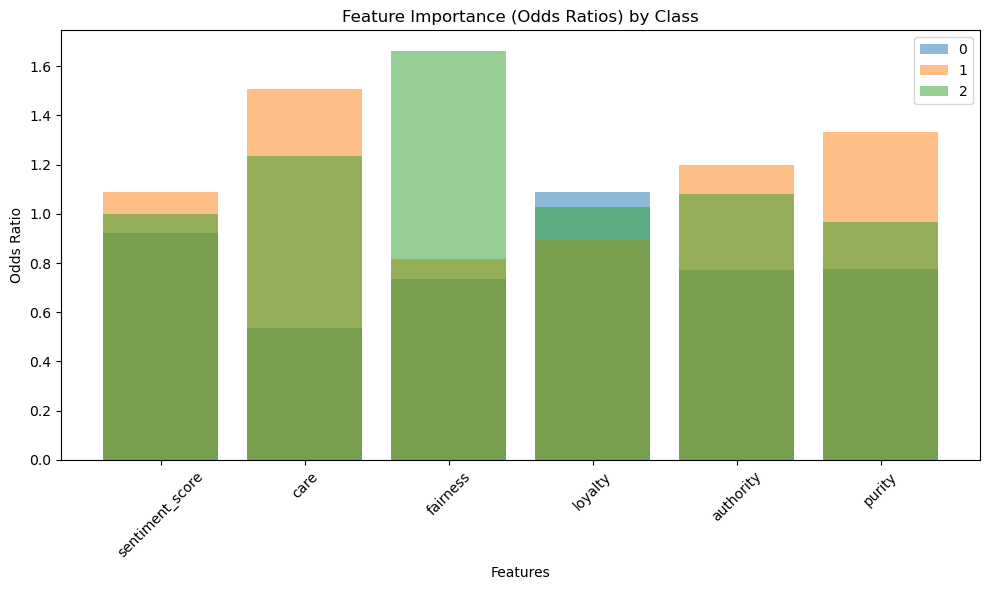

In [7]:
# Predicting abortion stance (life, choice, neutral) based on morality and sentiment without looking at p values 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load your data
df = pd.read_csv('/Volumes/Repository/cleaned_dataset.csv')

# Exclude 'throw out' category
df = df[df['prolife_prochoice'] != 'throw_out']

# Drop rows where the target variable 'prolife_prochoice' contains NaN
df = df.dropna(subset=['prolife_prochoice'])

# Prepare your features (X) and target variable (y)
X = df[['sentiment_score', 'care', 'fairness', 'loyalty', 'authority', 'purity']]
y = df['prolife_prochoice'].map({'neutral': 0, 'life': 1, 'choice': 2})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print odds ratios
feature_names = X.columns
classes = model.classes_
odds_ratios = np.exp(model.coef_)

for i, class_name in enumerate(classes):
    print(f"\nOdds Ratios for {class_name}:")
    for j, feature in enumerate(feature_names):
        print(f"{feature}: {odds_ratios[i][j]:.2f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(classes):
    plt.bar(feature_names, odds_ratios[i], alpha=0.5, label=class_name)
plt.xlabel('Features')
plt.ylabel('Odds Ratio')
plt.title('Feature Importance (Odds Ratios) by Class')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/r0/3946nhpj0txd6j3_ykb7rykm0000gn/T/ipykernel_4113/2668579045.py:13: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Volumes/Repository/cleaned_dataset.csv')


Best Parameters: {'logreg__C': 0.01}
Best Cross-Validation Accuracy: 0.57

Logistic Regression Model Performance on Test Set
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.34      0.89      0.49    299379
           1       0.51      0.37      0.43    431151
           2       0.80      0.46      0.59    861702

    accuracy                           0.52   1592232
   macro avg       0.55      0.57      0.50   1592232
weighted avg       0.64      0.52      0.53   1592232


Best Random Forest Parameters: {'rf__max_depth': 30, 'rf__n_estimators': 100}
Best Cross-Validation Accuracy for Random Forest: 0.64

Random Forest Model Performance on Test Set
Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.39      0.88      0.54    299379
           1       0.60      0.45      0.52    431151
           2       0.84      0.58      0.69    861702

    accuracy                           0.60   1592232
   macro avg 

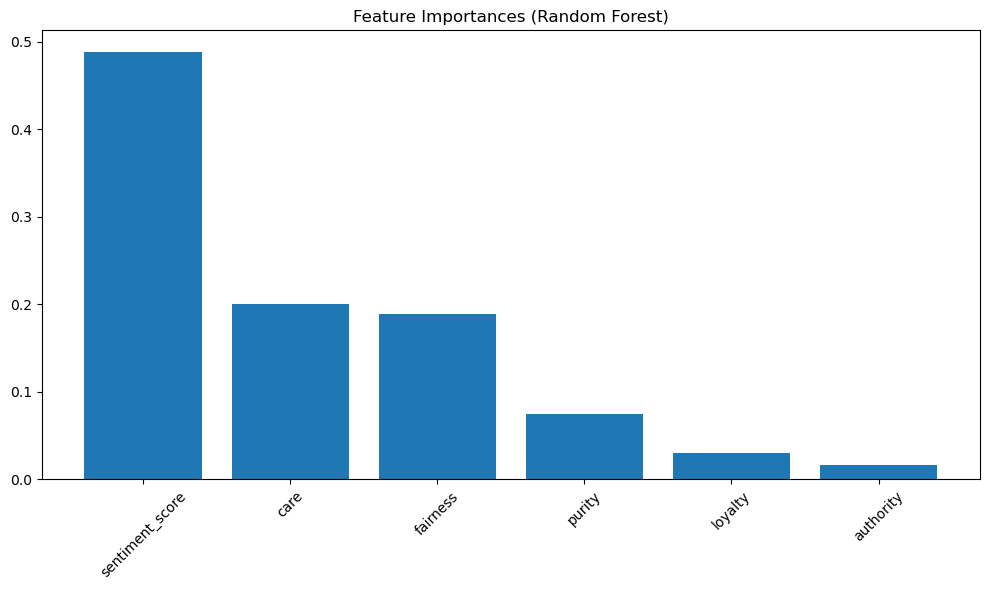

In [13]:
#Cross validation and regularization 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# Load your data
df = pd.read_csv('/Volumes/Repository/cleaned_dataset.csv')

# Exclude 'throw out' category
df = df[df['prolife_prochoice'] != 'throw_out']

# Drop rows where the target variable 'prolife_prochoice' contains NaN
df = df.dropna(subset=['prolife_prochoice'])

# Prepare your features (X) and target variable (y)
X = df[['sentiment_score', 'care', 'fairness', 'loyalty', 'authority', 'purity']]
y = df['prolife_prochoice'].map({'neutral': 0, 'life': 1, 'choice': 2})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define a pipeline for scaling and logistic regression
pipe_lr = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Define hyperparameters to tune
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe_lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

# Train the logistic regression model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate on test set
y_pred = best_model.predict(X_test)
print("\nLogistic Regression Model Performance on Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Compare with a Random Forest classifier
pipe_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('rf', RandomForestClassifier(random_state=42))
])

# Define hyperparameters for Random Forest
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, 30],
}

# Perform grid search for Random Forest
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Get best parameters and best score for Random Forest
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"\nBest Random Forest Parameters: {best_params_rf}")
print(f"Best Cross-Validation Accuracy for Random Forest: {best_score_rf:.2f}")

# Train and evaluate Random Forest model
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest Model Performance on Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf))

# Optional: Plot feature importances for Random Forest
importances = best_rf.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


In [18]:
#Predicting abortion stance (life, choice, neutral) based on morality and sentiment 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm

# Load your data
df = pd.read_csv('/Volumes/Repository/cleaned_dataset.csv')

# Exclude 'throw out' category and drop NaN values
df = df[df['prolife_prochoice'] != 'throw_out'].dropna(subset=['prolife_prochoice'])

# Prepare features (X) and target variable (y)
X = df[['sentiment_score', 'care', 'fairness', 'loyalty', 'authority', 'purity']]
y = df['prolife_prochoice'].map({'neutral': 0, 'life': 1, 'choice': 2})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add constant term to the features
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Fit multinomial logistic regression model
model = sm.MNLogit(y_train, X_train_const)
results = model.fit()

# Print summary of the model
print(results.summary())

# Make predictions
y_pred = results.predict(X_test_const).idxmax(axis=1)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print odds ratios with confidence intervals
print("\nOdds Ratios and 95% Confidence Intervals:")
params = results.params
conf_int = results.conf_int()
odds_ratios = np.exp(params)
odds_ratios_ci = np.exp(conf_int)

for i, class_name in enumerate(['life', 'choice']):  # Assuming 'neutral' is the reference category
    print(f"\nFor {class_name}:")
    for j, feature in enumerate(X.columns):
        or_value = odds_ratios.iloc[i+1, j]
        ci_lower = odds_ratios_ci.iloc[i+1, j][0]
        ci_upper = odds_ratios_ci.iloc[i+1, j][1]
        p_value = results.pvalues.iloc[i+1, j]
        print(f"{feature}: OR = {or_value:.2f}, 95% CI: ({ci_lower:.2f}, {ci_upper:.2f}), p-value: {p_value:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(['life', 'choice']):
    plt.subplot(1, 2, i+1)
    or_values = odds_ratios.iloc[i+1, 1:]  # Exclude the constant term
    plt.bar(X.columns, or_values)
    plt.xlabel('Features')
    plt.ylabel('Odds Ratio')
    plt.title(f'Feature Importance (Odds Ratios) for {class_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

/var/folders/r0/3946nhpj0txd6j3_ykb7rykm0000gn/T/ipykernel_4113/4017398337.py:10: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Volumes/Repository/cleaned_dataset.csv')


Optimization terminated successfully.
         Current function value: 0.868451
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:      prolife_prochoice   No. Observations:              6368928
Model:                        MNLogit   Df Residuals:                  6368914
Method:                           MLE   Df Model:                           12
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.1318
Time:                        11:01:03   Log-Likelihood:            -5.5311e+06
converged:                       True   LL-Null:                   -6.3707e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
prolife_prochoice=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8800      0.002    440.528      0.000       0.876       0.884
x1

AttributeError: 'numpy.ndarray' object has no attribute 'idxmax'

In [21]:
#Prediction of abortion stance (life, choice) based on morality and sentiment 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Filter the data for binary logistic regression (life vs choice)
binary_df = df[df['prolife_prochoice'].isin(['life', 'choice'])]  # Keep only life (prolife) and choice (prochoice)
X = binary_df[['sentiment_score', 'care', 'fairness', 'loyalty', 'authority', 'purity']]
y = binary_df['prolife_prochoice'].map({'life': 0, 'choice': 1})  # Map life to 0 and choice to 1 for binary classification

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add constant term for statsmodels
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Fit binary logistic regression model
model = sm.Logit(y_train, X_train_const)
result = model.fit()

# Print summary
print(result.summary())

# Get odds ratios
odds_ratios = np.exp(result.params)
print(f"\nOdds Ratios:\n{odds_ratios}")

# Predictions
y_pred = result.predict(X_test_const).round()

# Accuracy
accuracy = (y_pred == y_test).mean()
print(f"\nAccuracy: {accuracy:.2f}")


Optimization terminated successfully.
         Current function value: 0.576512
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      prolife_prochoice   No. Observations:              5171412
Model:                          Logit   Df Residuals:                  5171405
Method:                           MLE   Df Model:                            6
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                 0.09438
Time:                        11:21:36   Log-Likelihood:            -2.9814e+06
converged:                       True   LL-Null:                   -3.2921e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7924      0.001    769.088      0.000       0.790       0.794
x1            -0.0934      0.

In [22]:
# Interaction of sentiment and morality on abortion stance (life, choice)
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Filter the data for binary logistic regression (life vs choice)
binary_df = df[df['prolife_prochoice'].isin(['life', 'choice'])]  # Keep only life (prolife) and choice (prochoice)
X = binary_df[['sentiment_score', 'care', 'fairness', 'loyalty', 'authority', 'purity']]
y = binary_df['prolife_prochoice'].map({'life': 0, 'choice': 1})  # Map life to 0 and choice to 1 for binary classification

# Create interaction terms between sentiment and morality variables
X['sentiment_care'] = X['sentiment_score'] * X['care']
X['sentiment_fairness'] = X['sentiment_score'] * X['fairness']
X['sentiment_loyalty'] = X['sentiment_score'] * X['loyalty']
X['sentiment_authority'] = X['sentiment_score'] * X['authority']
X['sentiment_purity'] = X['sentiment_score'] * X['purity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add constant term for statsmodels
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Fit binary logistic regression model with interaction terms
model = sm.Logit(y_train, X_train_const)
result = model.fit()

# Print summary
print(result.summary())

# Get odds ratios for the interaction terms
odds_ratios = np.exp(result.params)
print(f"\nOdds Ratios:\n{odds_ratios}")

# Predictions
y_pred = result.predict(X_test_const).round()

# Accuracy
accuracy = (y_pred == y_test).mean()
print(f"\nAccuracy: {accuracy:.2f}")


/var/folders/r0/3946nhpj0txd6j3_ykb7rykm0000gn/T/ipykernel_4113/718604197.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sentiment_care'] = X['sentiment_score'] * X['care']
/var/folders/r0/3946nhpj0txd6j3_ykb7rykm0000gn/T/ipykernel_4113/718604197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sentiment_fairness'] = X['sentiment_score'] * X['fairness']
/var/folders/r0/3946nhpj0txd6j3_ykb7rykm0000gn/T/ipykernel_4113/718604197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a c

Optimization terminated successfully.
         Current function value: 0.572221
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      prolife_prochoice   No. Observations:              5171412
Model:                          Logit   Df Residuals:                  5171400
Method:                           MLE   Df Model:                           11
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.1011
Time:                        16:07:41   Log-Likelihood:            -2.9592e+06
converged:                       True   LL-Null:                   -3.2921e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7930      0.001    764.189      0.000       0.791       0.795
x1            -0.0523      0.